# An Analysis of the City of Toronto’s Fire Response between 2011-2019
## by The City of Toronto Department of Pandas¶

The goal of this project is to create a predictive model capable of determining response time given inputs such as day, time, or location. Exploratory data analysis is iterative, therefore, until our exploratory data analysis is conducted, we will not know exactly which features will be used to implement the model, nor do we know exactly what type of prediction model will be used (e.g., linear regression, logistic regression, or other approaches as suitable). However, an example of our anticipated model can be seen below.

###  Objectives
The questions we hope to answer with our exploratory data analysis are:
- Are there temporal trends in factors such as response time, damages, or other relevant factors?

- Identify the characteristics of fires with extensive damage/casualties. What factors make a fire most/least likely to cause extensive damage/casualties?

- Analyze and intersect our datasets to find the closest TFS station to each fire. Stations that frequently fail to respond in a timely manner to nearby fires may require more resources from the city.

- Identify the common fire incidents and causes in each ward.

- Optional: Is there a correlation between the resources TFS deploys (number of personnel, vehicles, etc.) during incidents and damages (such as casualties/financial)?

- Optional: Overlay incidents with socio-economic profiles of each neighborhood and analyze whether TFS services are equally and equitably distributed across the city. Are TFS services biased when responding to certain incidents or wards of the city?
- test - Sami

## Setup Notebook

In [67]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [68]:
# Import 3rd party libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split


# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Overview

The primary dataset to be used for this project includes information about Toronto’s Fire Incidents (https://open.toronto.ca/dataset/fire-incidents/). This data is a .csv file from the City of Toronto’s open data portal with details of over 17,000 fire incidents between January 1, 2011, to June 30, 2019. The dataset contains 43 columns that describe the geographic location of the fire, the TFS response, impact of the fire, suspected cause, and details of the site (e.g., building condition and presence of sprinklers or alarms). The dataset contains categorical variables, many null values, and string values in many of the columns. Extensive data cleaning and data wrangling as well as feature engineering is needed for this project. Feature engineering techniques such as categorical encoding, datetime extraction, imputation, etc. will be used for this project. The appendix shows the data types and categories of each of the columns in the dataset.

The rest of the datasets described in this paragraph are secondary datasets that will only be used if time allows. The second dataset is the City of Toronto Wards data which includes spatial boundaries that we can overlay with the fire incident data for visualization purposes (https://open.toronto.ca/dataset/city-wards/). The third dataset is a .GeoJSON file with Toronto Fire station locations (https://open.toronto.ca/dataset/fire-station-locations/). Finally, if time allows, we will use a fourth dataset of Toronto’s neighbourhoods which includes information on variables such as income, population, household type, and education (https://open.toronto.ca/dataset/neighbourhood-profiles/).

# Import Data
Let's import the training datasets.

### Toronto Fire Incidents

In [69]:
fire_data = pd.read_csv('Fire Incidents Data.csv')

In [70]:
fire_data.head(10)

,_id,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,...,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties
0,578689,81 - Engine Area,NaN,NaN,0,0,15000.0,NaN,NaN,2018-02-24T21:12:00,...,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, ...",2018-02-24T21:04:29,2018-02-24T21:10:11,0
1,578690,"75 - Trash, rubbish area (outside)",NaN,NaN,0,0,50.0,NaN,NaN,2018-02-24T21:29:42,...,NaN,NaN,NaN,NaN,NaN,NaN,2 - Fire with no evidence from street,2018-02-24T21:24:43,2018-02-24T21:29:31,0
2,578691,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-25T13:29:59,2018-02-25T13:36:49,0
3,578692,"75 - Trash, rubbish area (outside)",01 - Normal (no change),1 - No business interruption,0,0,0.0,0.0,NaN,2018-02-25T14:19:25,...,98 - Not applicable: Alarm operated OR presenc...,9 - Type undetermined,"8 - Not applicable: No alarm, no persons present",99 - Undetermined,8 - Not applicable - no sprinkler system present,9 - Undetermined,3 - Fire with smoke showing only - including v...,2018-02-25T14:13:39,2018-02-25T14:18:07,0
4,578693,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-25T18:20:43,2018-02-25T18:26:19,0
5,578694,81 - Engine Area,NaN,NaN,0,0,1500.0,NaN,NaN,2018-02-25T18:38:00,...,NaN,NaN,NaN,NaN,NaN,NaN,4 - Flames showing from small area (one storey...,2018-02-25T18:31:19,2018-02-25T18:35:17,0
6,578695,22 - Sleeping Area or Bedroom (inc. patients r...,01 - Normal (no change),1 - No business interruption,0,0,2000.0,0.0,NaN,2018-02-26T18:28:00,...,98 - Not applicable: Alarm operated OR presenc...,8 - Not applicable - no smoke alarm or presenc...,7 - Not applicable: Occupant(s) first alerted ...,2 - Confined to part of room/area of origin,8 - Not applicable - no sprinkler system present,3 - No sprinkler system,2 - Fire with no evidence from street,2018-02-26T18:18:55,2018-02-26T18:24:47,0
7,578696,55 - Mechanical/Electrical Services Room,01 - Normal (no change),2 - May resume operations within a week,0,0,100000.0,0.0,NaN,2018-02-27T10:57:32,...,98 - Not applicable: Alarm operated OR presenc...,8 - Not applicable - no smoke alarm or presenc...,2 - Some persons (at risk) self evacuated as a...,"7 - Spread to other floors, confined to building",8 - Not applicable - no sprinkler system present,3 - No sprinkler system,2 - Fire with no evidence from street,2018-02-27T10:28:12,2018-02-27T10:35:13,0
8,578697,28 - Office,01 - Normal (no change),1 - No business interruption,0,0,5000.0,0.0,NaN,2018-02-25T15:57:00,...,98 - Not applicable: Alarm operated OR presenc...,2 - Hardwired (standalone),1 - All persons (at risk of injury) self evacu...,"4 - Spread beyond room of origin, same floor",3 - Did not activate: fire too small to trigge...,1 - Full sprinkler system present,4 - Flames showing from small area (one storey...,2018-02-25T15:48:34,2018-02-25T15:52:04,0
9,578698,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-26T15:32:11,2018-02-26T15:37:40,0


### Toronto Wards

For now, I have commented out the map plot until we need it again.

In [71]:
ward = gpd.read_file('25-ward-model-december-2018-wgs84-latitude-longitude') #importing shapefile

# # View GeoDataFrame
ward.head()
# ward.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

,AREA_ID,AREA_TYPE,AREA_S_CD,AREA_L_CD,AREA_NAME,X,Y,LONGITUDE,LATITUDE,geometry
0,2551040,WD18,16,16,Don Valley East,318237.290,4844000.0,-79.33298,43.739716,"POLYGON ((-79.31335 43.71699, -79.31950 43.715..."
1,2551044,WD18,03,03,Etobicoke-Lakeshore,303099.474,4831000.0,-79.52087,43.621646,"POLYGON ((-79.49777 43.65198, -79.49725 43.651..."
2,2551048,WD18,15,15,Don Valley West,314825.876,4843000.0,-79.37536,43.728396,"POLYGON ((-79.35232 43.71573, -79.35209 43.715..."
3,2551052,WD18,23,23,Scarborough North,324522.149,4852000.0,-79.25467,43.809672,"POLYGON ((-79.22591 43.83960, -79.22556 43.839..."
4,2551056,WD18,11,11,University-Rosedale,313306.543,4837000.0,-79.39432,43.671139,"POLYGON ((-79.39004 43.69050, -79.39004 43.690..."


### Toronto Fire Station Locations

In [72]:
fire_stations = pd.read_csv('torontofirestation_locations.csv')
fire_stations = fire_stations.rename({'Latitude ': 'Lat', 'Longitude': 'Lon'}, axis = 1)
fire_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Station Number  85 non-null     object 
 1   Address         85 non-null     object 
 2   Lat             85 non-null     float64
 3   Lon             85 non-null     float64
dtypes: float64(2), object(2)
memory usage: 2.8+ KB


In [73]:
fire_stations_gdf = gpd.GeoDataFrame(fire_stations, geometry = gpd.points_from_xy(fire_stations.Lon, fire_stations.Lat))
fire_stations_gdf.head()
# fire_stations_gdf.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

,Station Number,Address,Lat,Lon,geometry
0,Station 111,3300 Bayview Avenue,43.790180,-79.393326,POINT (-79.39333 43.79018)
1,Station 112,5700 Bathurst Street,43.776370,-79.443620,POINT (-79.44362 43.77637)
2,Station 113,700 Seneca Hill Drive,43.793220,-79.350350,POINT (-79.35035 43.79322)
3,Station 114,12 Canterbury Place,43.772680,-79.414960,POINT (-79.41496 43.77268)
4,Station 115,115 Parkway Forest Drive,43.774208,-79.340829,POINT (-79.34083 43.77421)


Text(91.52006375671796, 0.5, 'Latitude')

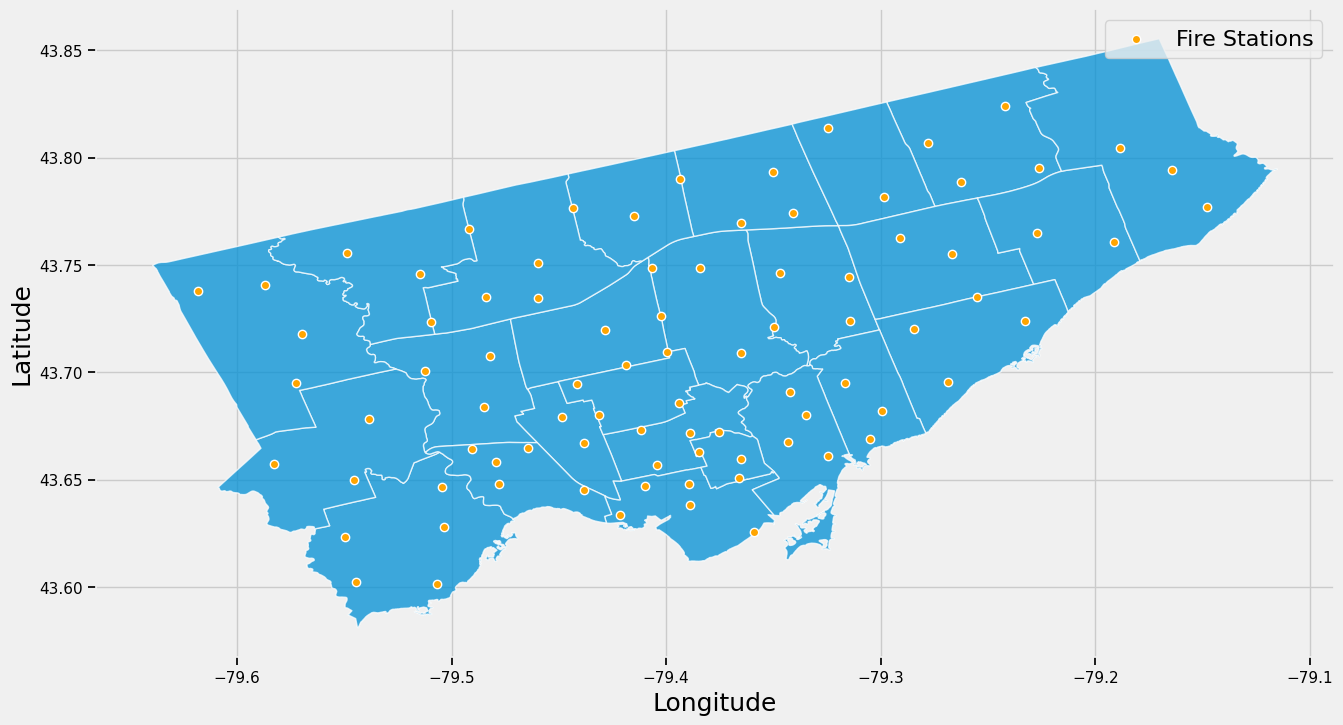

In [74]:
# Plot of the toronto fire station locations and wards
ax = ward.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)

fire_stations_gdf.plot(ax = ax, color = 'orange', edgecolor = 'w', label = 'Fire Stations')

plt.legend(fontsize = 16)

plt.xlabel('Longitude', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)

# Data Cleaning

In [75]:
fire_data.head()

,_id,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,...,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties
0,578689,81 - Engine Area,NaN,NaN,0,0,15000.0,NaN,NaN,2018-02-24T21:12:00,...,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, ...",2018-02-24T21:04:29,2018-02-24T21:10:11,0
1,578690,"75 - Trash, rubbish area (outside)",NaN,NaN,0,0,50.0,NaN,NaN,2018-02-24T21:29:42,...,NaN,NaN,NaN,NaN,NaN,NaN,2 - Fire with no evidence from street,2018-02-24T21:24:43,2018-02-24T21:29:31,0
2,578691,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-25T13:29:59,2018-02-25T13:36:49,0
3,578692,"75 - Trash, rubbish area (outside)",01 - Normal (no change),1 - No business interruption,0,0,0.0,0.0,NaN,2018-02-25T14:19:25,...,98 - Not applicable: Alarm operated OR presenc...,9 - Type undetermined,"8 - Not applicable: No alarm, no persons present",99 - Undetermined,8 - Not applicable - no sprinkler system present,9 - Undetermined,3 - Fire with smoke showing only - including v...,2018-02-25T14:13:39,2018-02-25T14:18:07,0
4,578693,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-25T18:20:43,2018-02-25T18:26:19,0


In [76]:
fire_data.groupby('Material_First_Ignited').size().sort_values(ascending = False)

Material_First_Ignited
99 - Undetermined (formerly 98)                                 2390
46 - Rubbish, Trash, Waste                                      1827
74 - Cooking Oil, Grease                                        1457
47 - Vehicle                                                    1212
43 - Electrical Wiring Insulation                               1111
97 - Other                                                       954
55 - Wood                                                        533
56 - Paper, Cardboard                                            475
54 - Plastic                                                     473
14 - Interior Wall/Ceiling                                       402
23 - Cabinetry                                                   345
16 - Insulation                                                  332
21 - Upholstered Sofa, Chair, etc.                               329
31 - Mattress, Pillow                                            274
51 - Bush, 

In [77]:
fire_data.groupby('Method_Of_Fire_Control').size().sort_values(ascending = False)

Method_Of_Fire_Control
1 - Extinguished by fire department     11015
3 - Extinguished by occupant             3036
4 - Fire self extinguished                704
2 - Extinguished by automatic system      505
5 - Action taken unclassified             362
dtype: int64

## Irrelevant Data
First, we can begin by eliminating columns that we know, for sure, that we do not need. At the moment, this includes the "Incident_Number" and "Exposure" columns. "Incident_Number" because it is essentially equivalent to "_id", and "Exposure" because 98% of the data in this column are null.

In [78]:
drop = ['Area_of_Origin',
        'Building_Status',
        'Business_Impact',
        'Civilian_Casualties',
        'Count_of_Persons_Rescued',
        'Estimated_Dollar_Loss',
        'Estimated_Number_Of_Persons_Displaced',
        'Exposures',
        'Extent_Of_Fire',
        'Final_Incident_Type',
        'Fire_Alarm_System_Impact_on_Evacuation',
        'Fire_Alarm_System_Operation',
        'Fire_Alarm_System_Presence',
        'Fire_Under_Control_Time',
        'Ignition_Source',
        'Incident_Number',
        'Initial_CAD_Event_Type',
        'Intersection',
        'Last_TFS_Unit_Clear_Time',
        'Level_Of_Origin',
        'Material_First_Ignited',
        'Method_Of_Fire_Control',
        'Possible_Cause',
        'Property_Use',
        'Smoke_Alarm_at_Fire_Origin',
        'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
        'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
        'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
        'Smoke_Spread',
        'Sprinkler_System_Operation',
        'Sprinkler_System_Presence',
        'Status_of_Fire_On_Arrival',
        'Ext_agent_app_or_defer_time',
        'TFS_Firefighter_Casualties']

In [79]:
fire_data = fire_data.drop(drop, axis = 1)
fire_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17536 entries, 0 to 17535
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             17536 non-null  int64  
 1   Incident_Station_Area           17536 non-null  int64  
 2   Incident_Ward                   17451 non-null  float64
 3   Latitude                        17535 non-null  float64
 4   Longitude                       17535 non-null  float64
 5   Number_of_responding_apparatus  17536 non-null  int64  
 6   Number_of_responding_personnel  17536 non-null  int64  
 7   TFS_Alarm_Time                  17536 non-null  object 
 8   TFS_Arrival_Time                17536 non-null  object 
dtypes: float64(3), int64(4), object(2)
memory usage: 1.2+ MB


## Missing Data
Next, it is important to understand the number of null values and how to approach eliminating or changing those values. It appears that the columns with null values are split into approximately 5 different categories.

First, we have columns missing about 36% (n = ~6300) rows of their data (mostly columns pertaining to fire alarm, smoke alarm, or sprinklers).

Second, we have columns missing about 10% (n = ~1900) rows of their data.

Third, we have one column missing 85 rows of data. This is the "Incident_Ward" column.

Fourth, we have four columns all missing 1 value. "Intersection", "Longitude", "Latitude", and "Property_Use".

Fifth, we have 12 columns with zero null values.

In [80]:
fire_data.isnull().sum().sort_values(ascending = False)

Incident_Ward                     85
Latitude                           1
Longitude                          1
_id                                0
Incident_Station_Area              0
Number_of_responding_apparatus     0
Number_of_responding_personnel     0
TFS_Alarm_Time                     0
TFS_Arrival_Time                   0
dtype: int64

In [81]:
# Finding row that the singular Latitude, Longitude, Intersection null value is in
fire_data[fire_data['Latitude'].isnull()]

,_id,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Number_of_responding_apparatus,Number_of_responding_personnel,TFS_Alarm_Time,TFS_Arrival_Time
17500,596189,214,NaN,NaN,NaN,3,10,2011-09-26T18:55:12,2011-09-26T19:01:00


In [82]:
# I decided to just drop this one, since it is only one row.
fire_data.drop(fire_data.index[17500], axis = 0, inplace = True)
fire_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17535 entries, 0 to 17535
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             17535 non-null  int64  
 1   Incident_Station_Area           17535 non-null  int64  
 2   Incident_Ward                   17451 non-null  float64
 3   Latitude                        17535 non-null  float64
 4   Longitude                       17535 non-null  float64
 5   Number_of_responding_apparatus  17535 non-null  int64  
 6   Number_of_responding_personnel  17535 non-null  int64  
 7   TFS_Alarm_Time                  17535 non-null  object 
 8   TFS_Arrival_Time                17535 non-null  object 
dtypes: float64(3), int64(4), object(2)
memory usage: 1.3+ MB


In [83]:
# Finding rows that the 85 null Incident_Ward values are in. Is there a way for us to fill these? Why are they null? A lot seem to include "Steeles Ave"
fire_data[fire_data['Incident_Ward'].isnull()]

,_id,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Number_of_responding_apparatus,Number_of_responding_personnel,TFS_Alarm_Time,TFS_Arrival_Time
211,578900,411,NaN,43.766545,-79.564784,1,4,2018-01-20T06:06:46,2018-01-20T06:13:44
214,578903,242,NaN,43.825264,-79.300275,1,4,2018-03-04T08:59:06,2018-03-04T09:05:54
565,579254,211,NaN,43.836599,-79.251189,1,3,2018-02-12T09:01:02,2018-02-12T09:07:01
1417,580106,141,NaN,43.783218,-79.487306,10,34,2019-01-25T18:55:30,2019-01-25T18:56:07
2274,580963,113,NaN,43.808158,-79.371751,1,4,2019-04-21T22:16:18,2019-04-21T22:22:22
...,...,...,...,...,...,...,...,...,...
16839,595528,344,NaN,43.679410,-79.401270,5,18,2012-04-17T21:08:13,2012-04-17T21:13:00
16858,595547,411,NaN,43.764420,-79.570960,11,34,2017-08-21T17:17:01,2017-08-21T17:23:08
16925,595614,114,NaN,43.798000,-79.420080,6,24,2017-11-02T00:15:43,2017-11-02T00:22:44
17034,595723,113,NaN,43.797450,-79.330940,6,21,2017-12-01T17:40:21,2017-12-01T17:46:49


In [84]:
# Decided to fill these with 0 for now. If these incident number become important, perhaps we could use lat/long to find the right incident area
fire_data['Incident_Ward'] = fire_data['Incident_Ward'].fillna(0)

## Category 1 Data: Data with ~36% of data missing

Select columns with a high proportion (~36%) of null values. Most of these features have the exact same number of null values and relate to the presence of a fire alarm.

In [85]:
category_1 = []
for column in fire_data.columns:
    if fire_data[column].isnull().sum() >6000:
        category_1.append(column)
       # print(column + ' Unique Values: ' + str(fire_data[column].unique()))
        
category_1

[]

 The following features are obviously related to the presence of a smoke/fire alarm:
 ['Fire_Alarm_System_Impact_on_Evacuation',
 'Fire_Alarm_System_Operation',
 'Fire_Alarm_System_Presence',
 'Smoke_Alarm_at_Fire_Origin',
 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
 'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
 'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
 'Smoke_Spread',
 'Sprinkler_System_Operation',
 'Sprinkler_System_Presence']
 
We care about all fires, not just ones where a smoke alarm was present. There are four categories under 'Fire_Alarm_System_Presence':

Since there are already categories for whether or not a smoke alarm is present, we can't just assume that a blank row means there was no alarm. Instead, we can decide to use code '10 - No ' to indicate we do not know. There might be another feature that explains why these rows are empty. Let's start by looking at all the other features in rows where Fire_Alarm_System_Presence is null:

In [86]:
# #initialize new column indicating whether Fire_Alarm_System_Presence is null
# fire_data['null_fire_alarm_system'] = fire_data['Fire_Alarm_System_Presence'].isnull()

We can check whether the other columns are dependent on null_fire_system_alarm using a chi squared test. If pvalue < 0.05, the columns might be dependent on the null, and therefore might help us explain what's going on with all this missing data.

In [87]:
# cols_related_fire_alarm = []
#
# for column in fire_data.columns:
#     chisqt = pd.crosstab(fire_data['null_fire_alarm_system'], fire_data[column], margins=True)
#     value = np.array([chisqt.iloc[0][0:5].values,
#                       chisqt.iloc[1][0:5].values])
#     p_score = chi2_contingency(value)[1]
#     if p_score < 0.05:
#         cols_related_fire_alarm.append(column)
#         print(column)
#         print(chi2_contingency(value)[0:3])

Now let's look at the types of values we get in these low p-value features when fire_alarm_system_presence is null

In [88]:
# for column in cols_related_fire_alarm:
#     print(column)
#     print(fire_data[fire_data['Fire_Alarm_System_Presence'].isnull()][column].unique())

This isn't too helpful! There are a lot of categories in each of these columns and it's hard to distinguish which ones are actually related to whether fire_alarm_system_presence is null. Stopping here (Jeff, Nov 23) I think it's probably best to just assign these rows something like "undetermined"

fire_data[category_1].fillna('Undetermined')

In addition to null values, some columns have data that includes "undetermined", "not applicable", or something related. It would be useful to explore these. An example is below.

In [89]:
# fire_data.groupby('Smoke_Spread').size().sort_values(ascending = False)

One thing we noticed is that some of this fire incidents data does not actually pertain to fire incidents. Fire trucks typically respond to the scene in non-fire emergencies like medical. It would be useful for us to explore how much of this data does not actually pertain to fires. Perhaps this will allow us to reason why there are specific groupings of null values.

"Initial_CAD_Event_Type" appears to be the column that tells us what each call is for. There are 115 unique values in this column. Let's look at what they are.

UPDATE: It is very difficult to tell what some of the abbreviations in this column mean (e.g., VEF, FIHR, FICI, FIG, etc.) for now I will move on to other data cleaning until we find a document that will help us with this. If we cannot find documentation - @Jeff something your Dad could help with?

In [90]:
# fire_data['Initial_CAD_Event_Type'].nunique()

In [91]:
# fire_data.groupby('Final_Incident_Type').size().sort_values(ascending = False).head()

In [92]:
# fire_data.groupby('Initial_CAD_Event_Type').size().sort_values(ascending = False).head(20)

## Parsing DateTimes
We have 5 columns that should be DateTimes but are currently objects. Let's convert these.

In [93]:
datetime_columns = ['TFS_Alarm_Time', 'TFS_Arrival_Time']

# 'Ext_agent_app_or_defer_time', 'Fire_Under_Control_Time', 'Last_TFS_Unit_Clear_Time'

fire_data[datetime_columns] = fire_data[datetime_columns].apply(pd.to_datetime, format = '%Y-%m-%d %H:%M:%S')
fire_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17535 entries, 0 to 17535
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   _id                             17535 non-null  int64         
 1   Incident_Station_Area           17535 non-null  int64         
 2   Incident_Ward                   17535 non-null  float64       
 3   Latitude                        17535 non-null  float64       
 4   Longitude                       17535 non-null  float64       
 5   Number_of_responding_apparatus  17535 non-null  int64         
 6   Number_of_responding_personnel  17535 non-null  int64         
 7   TFS_Alarm_Time                  17535 non-null  datetime64[ns]
 8   TFS_Arrival_Time                17535 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(4)
memory usage: 1.3 MB


## Check for Duplicates

In [94]:
fire_data.duplicated().sum()

0

## Converting Incidents Data to GeoDataFrame

In [95]:
fire_data = gpd.GeoDataFrame(fire_data,
                             geometry = gpd.points_from_xy(fire_data.Longitude, fire_data.Latitude))

fire_data.head()

,_id,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Number_of_responding_apparatus,Number_of_responding_personnel,TFS_Alarm_Time,TFS_Arrival_Time,geometry
0,578689,441,1.0,43.686558,-79.599419,1,4,2018-02-24 21:04:29,2018-02-24 21:10:11,POINT (-79.59942 43.68656)
1,578690,116,18.0,43.766135,-79.390039,1,4,2018-02-24 21:24:43,2018-02-24 21:29:31,POINT (-79.39004 43.76613)
2,578691,221,21.0,43.743230,-79.245061,6,22,2018-02-25 13:29:59,2018-02-25 13:36:49,POINT (-79.24506 43.74323)
3,578692,133,5.0,43.708659,-79.478062,6,22,2018-02-25 14:13:39,2018-02-25 14:18:07,POINT (-79.47806 43.70866)
4,578693,132,8.0,43.718118,-79.443184,6,22,2018-02-25 18:20:43,2018-02-25 18:26:19,POINT (-79.44318 43.71812)


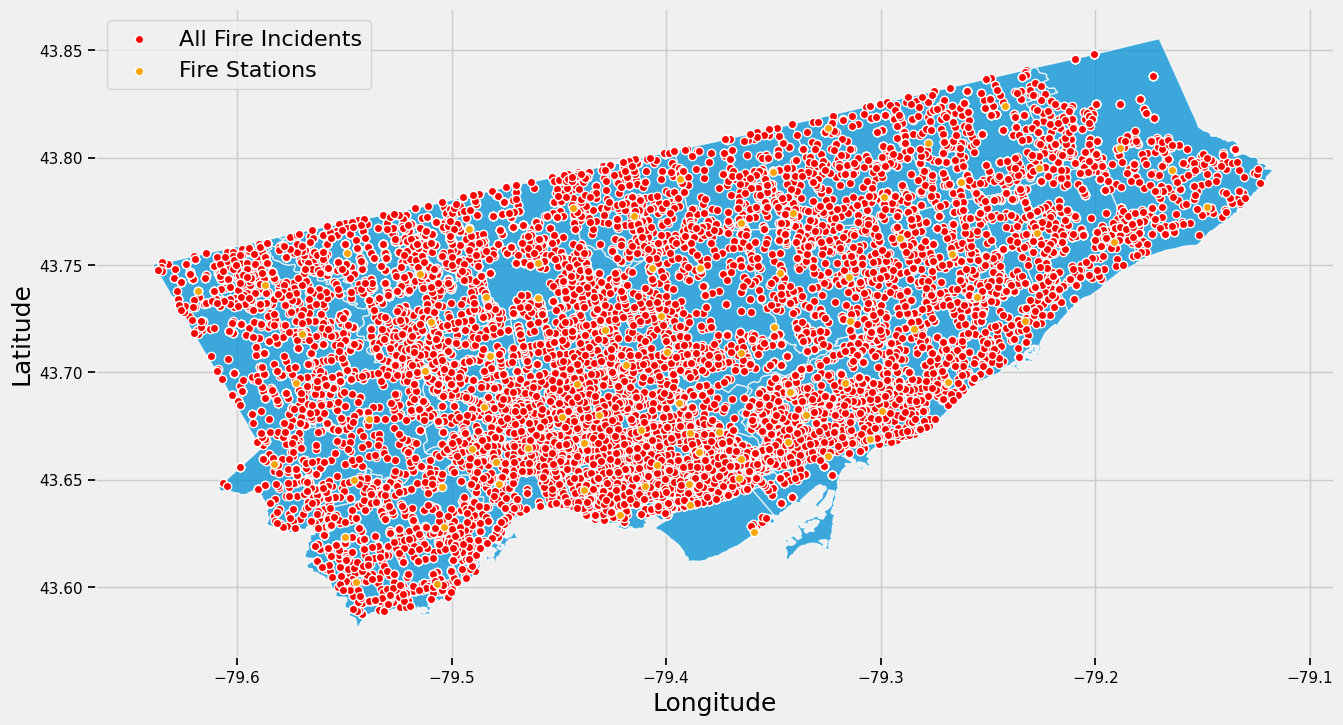

In [96]:
# Plot everything as a test
ax = ward.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)

fire_data.plot(ax = ax, color = 'red', edgecolor = 'w', label = 'All Fire Incidents')

fire_stations_gdf.plot(ax = ax, color = 'orange', edgecolor = 'w', label = 'Fire Stations')

plt.legend(fontsize = 16)

plt.xlabel('Longitude', fontsize = 18);
plt.ylabel('Latitude', fontsize = 18);

## Splitting "## - Description Columns"
Below I created a function that could take in the columns with the format "## - Description" and split them into two separate columns: one for the number and one for the text.

I tested it and it works, but I think we should wait to apply this to our DataFrame until we have selected the columns we are interested in because this function will almost double the number of columns we have.

In [97]:
def column_split(df, column, number_column, string_column):

    df[number_column], df[string_column] = df[column].str.split('-', 1).str

    return df[number_column], df[string_column]

In [98]:
# column_split(fire_data, 'Area_of_Origin', 'Area_Of_Origin_No', 'Area_Of_Origin_Descr')
# fire_data

EDA below is adapted from: https://www.kaggle.com/code/michaelsammons/toronto-fire-incidents-eda/notebook

# Target Variable: Response Time

#### Time of Incident

In [99]:
time=fire_data['TFS_Alarm_Time'].iloc[0]
fire_data['Hour']=fire_data['TFS_Alarm_Time'].apply(lambda time:time.hour)
fire_data['Month']=fire_data['TFS_Alarm_Time'].apply(lambda time:time.month)
fire_data['Day of Week']=fire_data['TFS_Alarm_Time'].apply(lambda time:time.dayofweek)

In [100]:
dmap={0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
fire_data['Day of Week']= fire_data['Day of Week'].map(dmap)

Text(0, 0.5, 'Count')

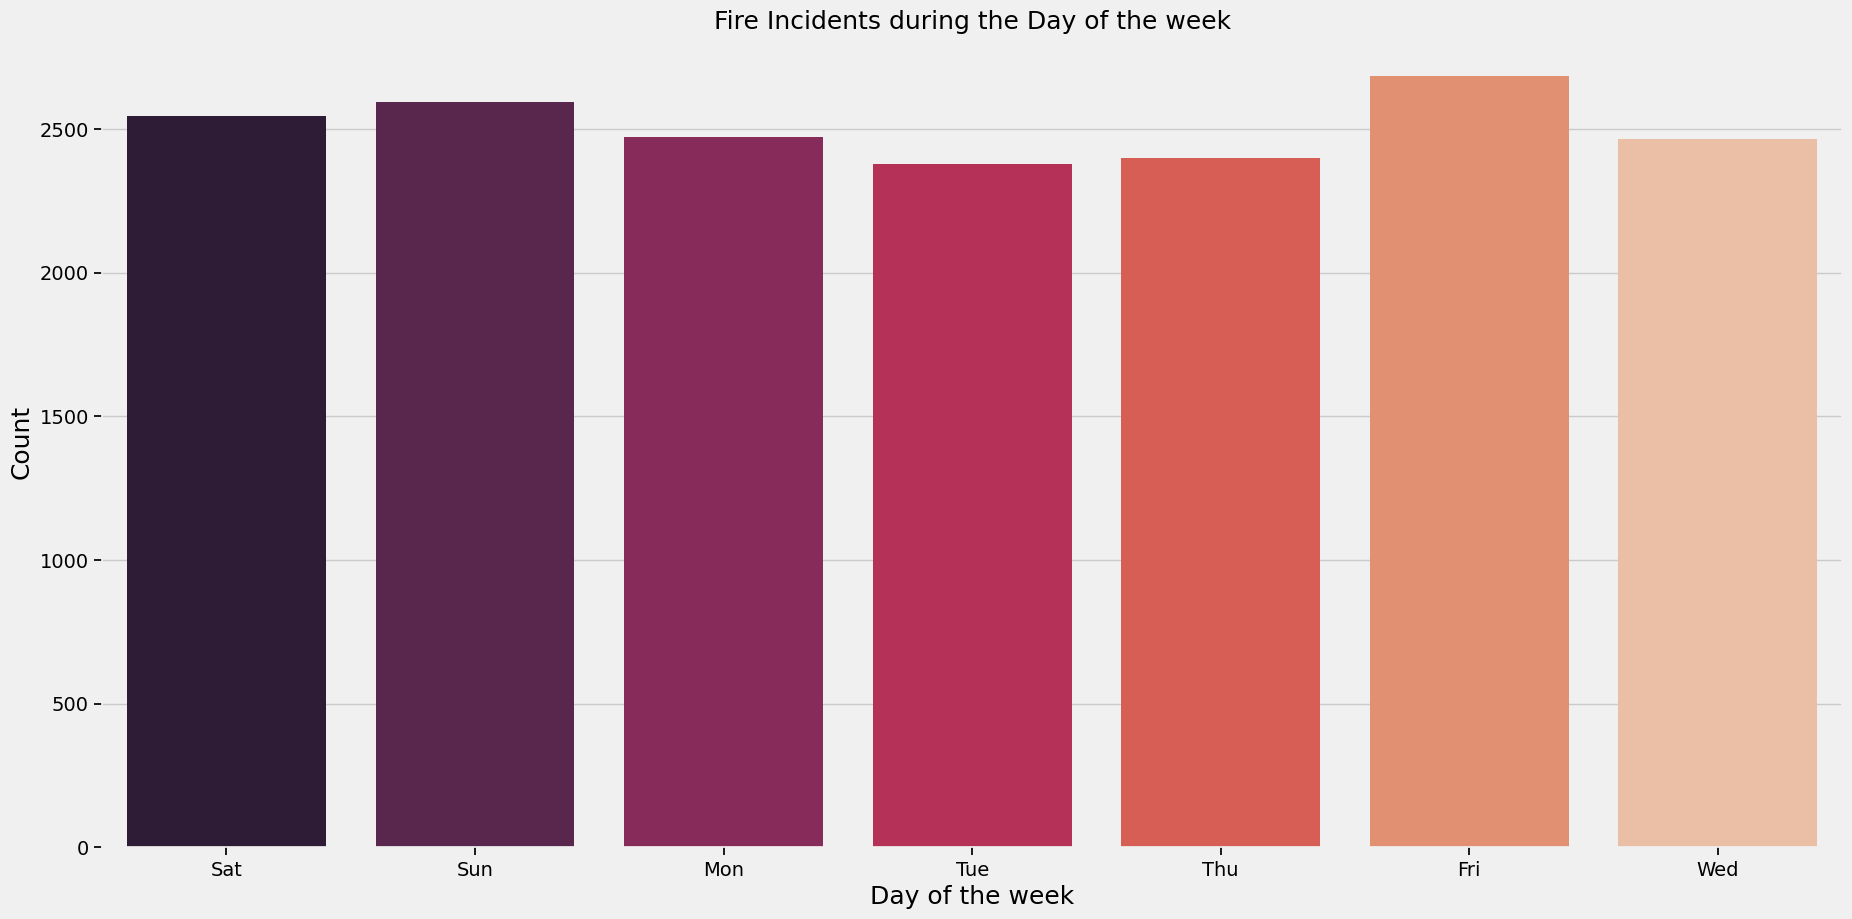

In [101]:
fig1 = plt.figure(figsize=(20, 10))
fig1 = sns.countplot(x='Day of Week',data=fire_data,palette='rocket')
plt.title('Fire Incidents during the Day of the week', fontsize=18)#title
fig1.xaxis.set_tick_params(labelsize=14)
fig1.yaxis.set_tick_params(labelsize=14)
fig1.set_xlabel('Day of the week', fontsize=18)#xlabel
fig1.set_ylabel('Count', fontsize=18)#ylabel

In [102]:
fire_data['Day of Week'].value_counts().head(20).to_frame(name='Count').reset_index().style.background_gradient(cmap='Reds', subset='Count')

,index,Count
0,Fri,2685
1,Sun,2593
2,Sat,2545
3,Mon,2472
4,Wed,2464
5,Thu,2398
6,Tue,2378


Takeaways: Days which are more likely to have incidents are:
- Friday
- Sunday
- Saturday
- Monday

#### Month

Text(0, 0.5, 'Count')

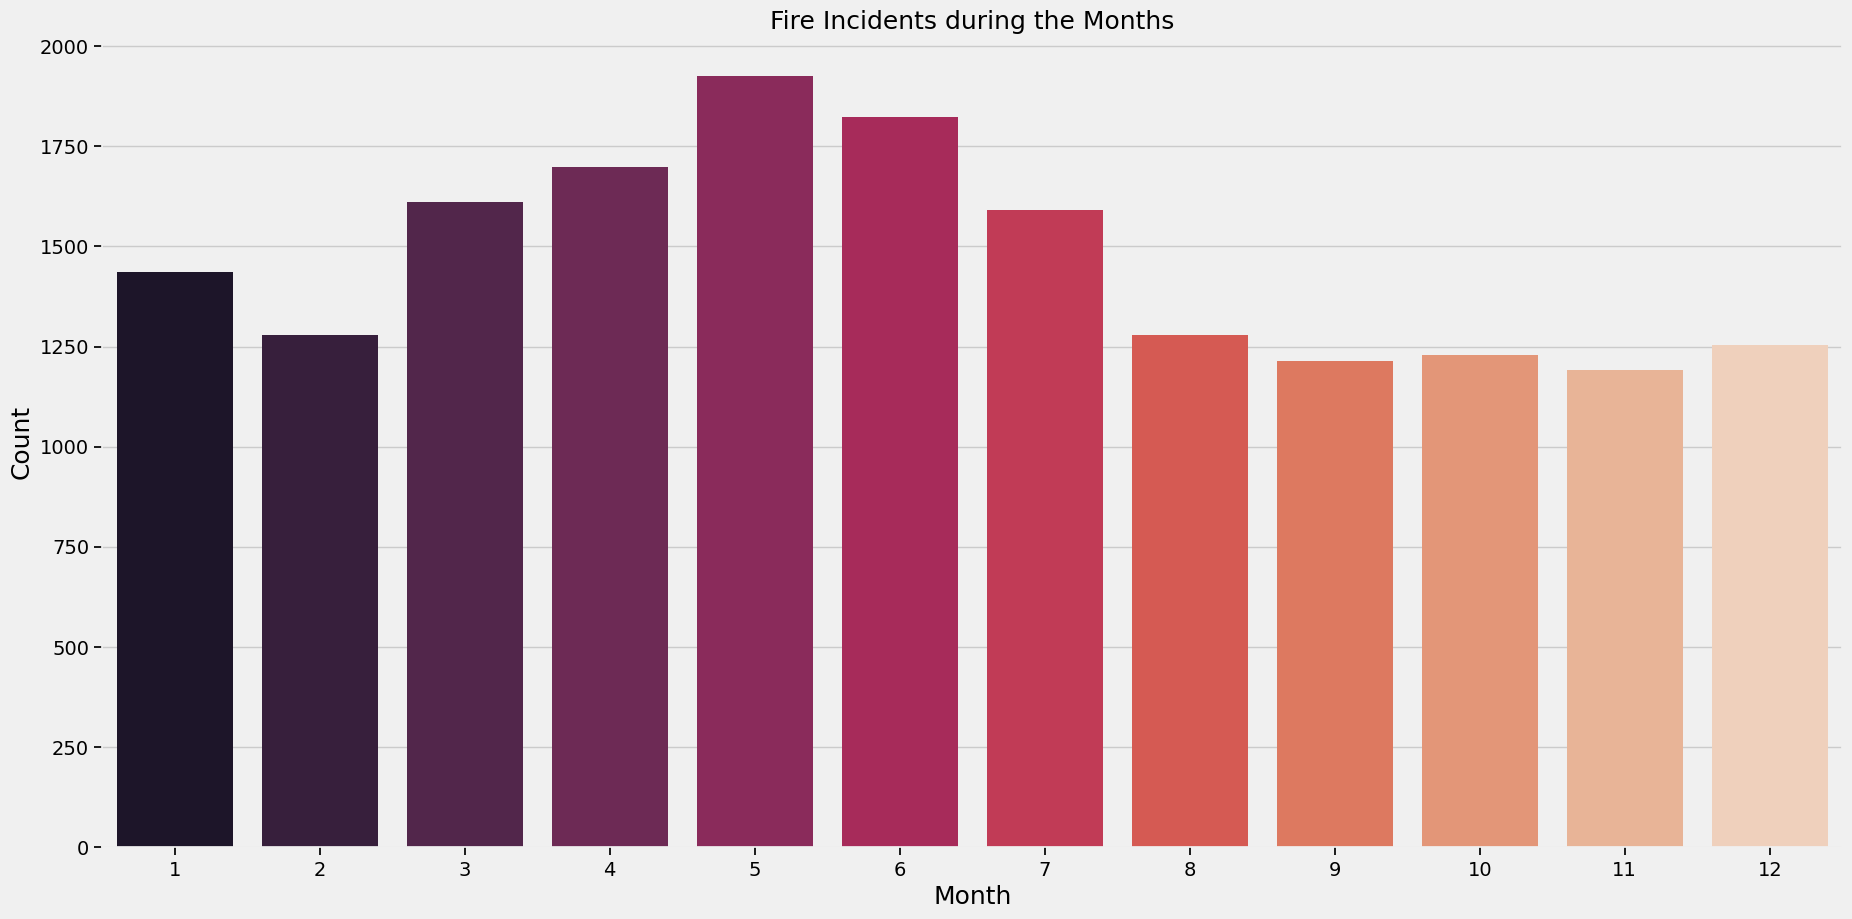

In [103]:
fig2 = plt.figure(figsize=(20, 10))
fig2 = sns.countplot(x='Month',data=fire_data,palette='rocket')
plt.title('Fire Incidents during the Months', fontsize=18)#title
fig2.xaxis.set_tick_params(labelsize=14)
fig2.yaxis.set_tick_params(labelsize=14)
fig2.set_xlabel('Month', fontsize=18)#xlabel
fig2.set_ylabel('Count', fontsize=18)#ylabel

In [104]:
fire_data['Month'].value_counts().head(20).to_frame(name='Count').reset_index().style.background_gradient(cmap='Reds', subset='Count')


,index,Count
0,5,1926
1,6,1822
2,4,1699
3,3,1612
4,7,1592
5,1,1437
6,2,1279
7,8,1279
8,12,1253
9,10,1230


Takeaways: Months which are more likely to have incidents are:
- May
- June
- April
- March

#### Year

In [105]:
fire_data['Year'] = fire_data['TFS_Alarm_Time'].apply(lambda time:time.year)

Text(0, 0.5, 'Count')

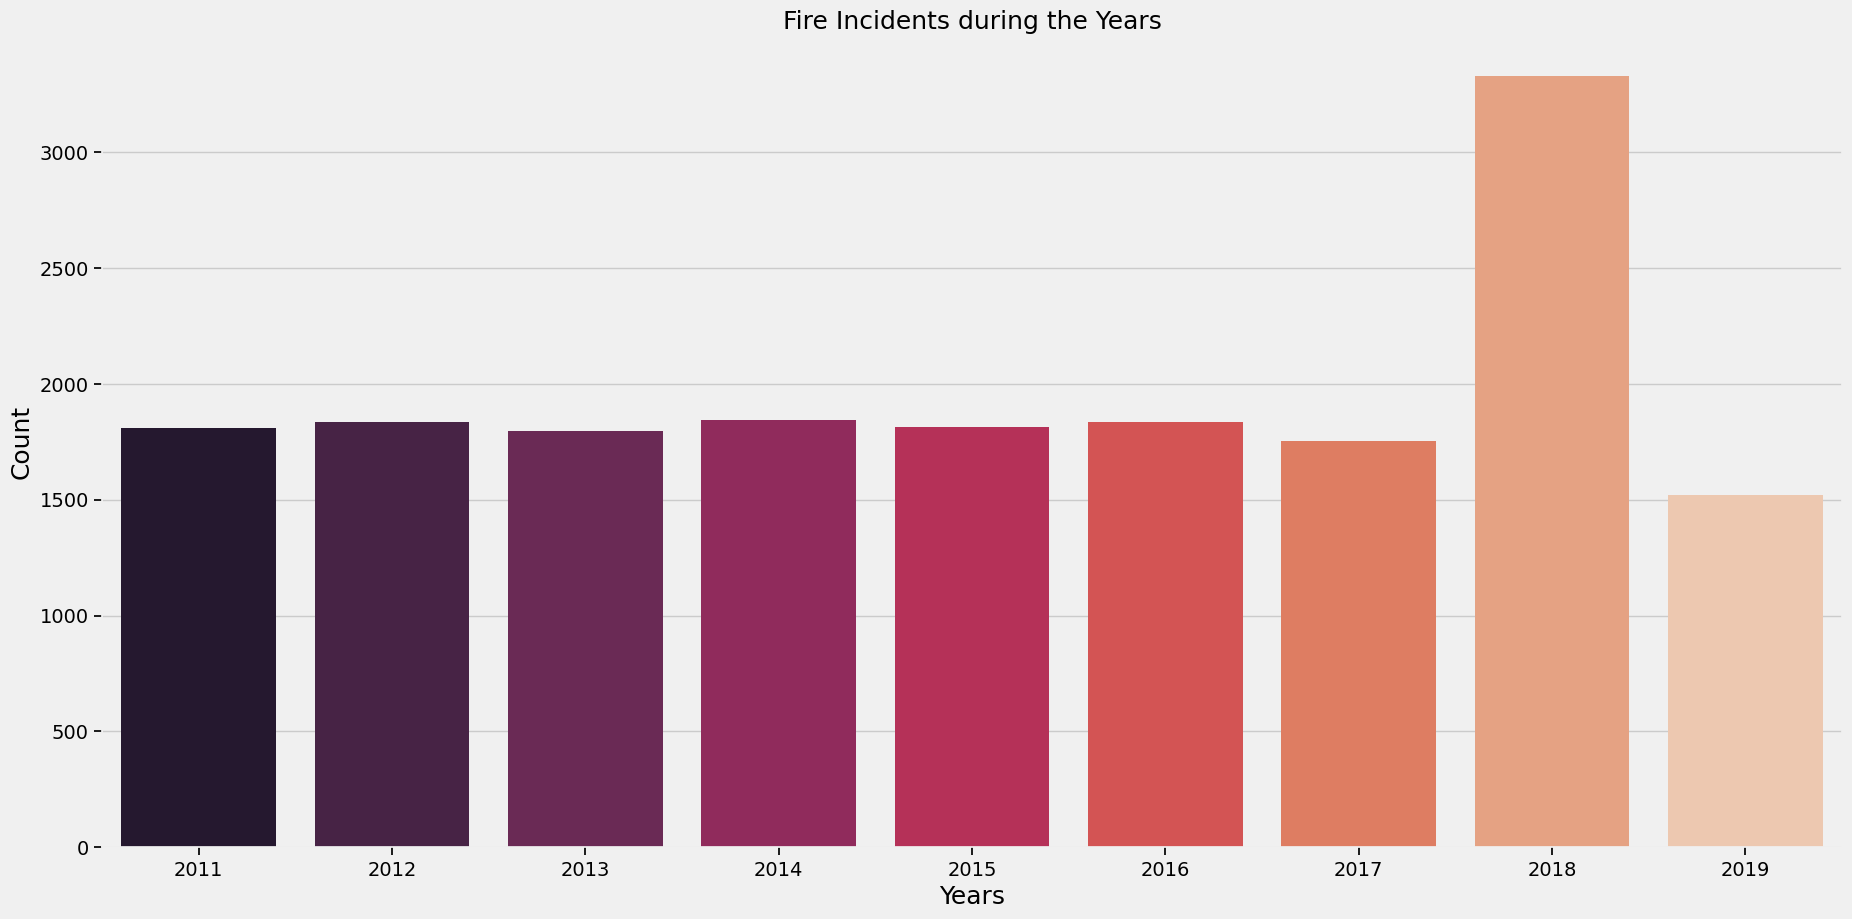

In [106]:

fig3 = plt.figure(figsize=(20, 10))
fig3 = sns.countplot(x='Year',data=fire_data,palette='rocket')
plt.title('Fire Incidents during the Years', fontsize=18)#title
fig3.xaxis.set_tick_params(labelsize=14)
fig3.yaxis.set_tick_params(labelsize=14)
fig3.set_xlabel('Years', fontsize=18)#xlabel
fig3.set_ylabel('Count', fontsize=18)#ylabel

In [107]:
fire_data['Year'].value_counts().head(20).to_frame(name='Count').reset_index().style.background_gradient(cmap = 'Reds', subset = 'Count')

,index,Count
0,2018,3330
1,2014,1843
2,2016,1834
3,2012,1834
4,2015,1816
5,2011,1810
6,2013,1796
7,2017,1753
8,2019,1519


Day

Text(0, 0.5, 'Count')

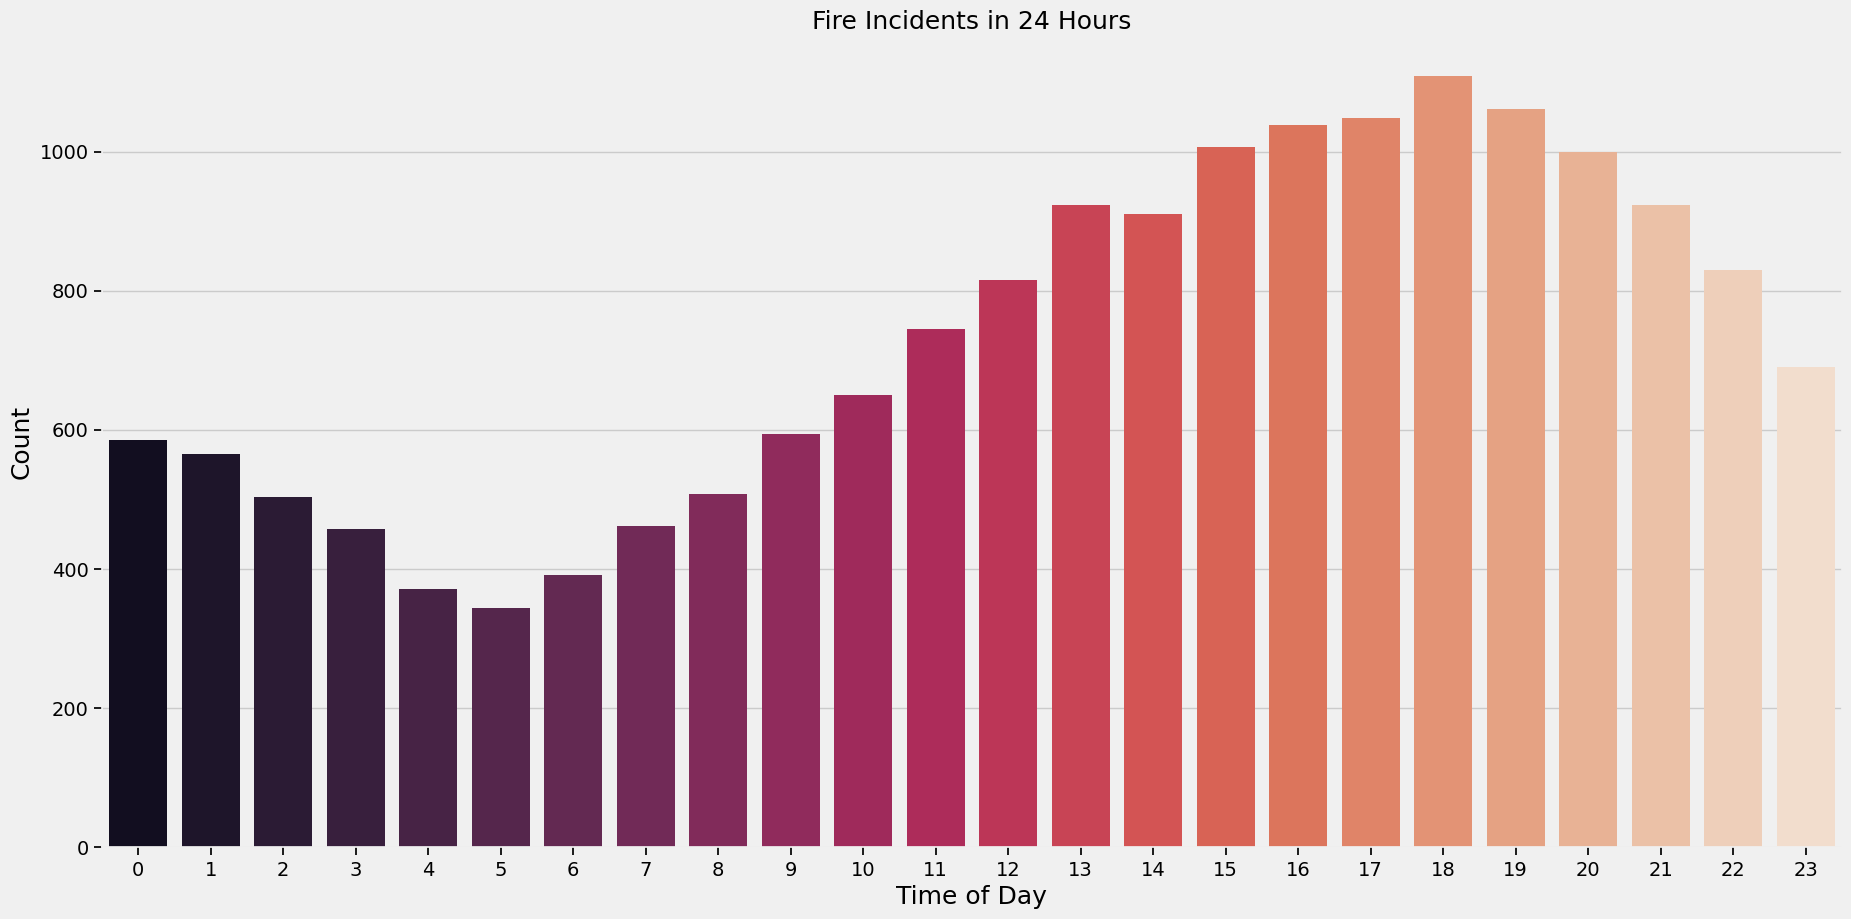

In [108]:
fig4 = plt.figure(figsize=(20, 10))
fig4 = sns.countplot(x='Hour',data=fire_data,palette='rocket')
plt.title('Fire Incidents in 24 Hours', fontsize=18)#title
fig4.xaxis.set_tick_params(labelsize=14)
fig4.yaxis.set_tick_params(labelsize=14)
fig4.set_xlabel('Time of Day', fontsize=18)#xlabel
fig4.set_ylabel('Count', fontsize=18)#ylabel

Most incidents happen between 12:00 and 22:00.

In [140]:
# Define Response Time
fire_data['response_time(min)'] =fire_data['TFS_Arrival_Time'] - fire_data['TFS_Alarm_Time']
fire_data['response_time(min)'] = fire_data['response_time(min)'].dt.total_seconds()/60
fire_data

,_id,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Number_of_responding_apparatus,Number_of_responding_personnel,TFS_Alarm_Time,TFS_Arrival_Time,geometry,Hour,Month,Day of Week,Year,response_time(min)
0,578689,441,1.0,43.686558,-79.599419,1,4,2018-02-24 21:04:29,2018-02-24 21:10:11,POINT (-79.59942 43.68656),21,2,Sat,2018,5.700000
1,578690,116,18.0,43.766135,-79.390039,1,4,2018-02-24 21:24:43,2018-02-24 21:29:31,POINT (-79.39004 43.76613),21,2,Sat,2018,4.800000
2,578691,221,21.0,43.743230,-79.245061,6,22,2018-02-25 13:29:59,2018-02-25 13:36:49,POINT (-79.24506 43.74323),13,2,Sun,2018,6.833333
3,578692,133,5.0,43.708659,-79.478062,6,22,2018-02-25 14:13:39,2018-02-25 14:18:07,POINT (-79.47806 43.70866),14,2,Sun,2018,4.466667
4,578693,132,8.0,43.718118,-79.443184,6,22,2018-02-25 18:20:43,2018-02-25 18:26:19,POINT (-79.44318 43.71812),18,2,Sun,2018,5.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17531,596220,222,20.0,43.729364,-79.280725,5,18,2018-02-24 02:30:33,2018-02-24 02:35:07,POINT (-79.28073 43.72936),2,2,Sat,2018,4.566667
17532,596221,121,8.0,43.738093,-79.420841,1,4,2018-02-24 17:55:59,2018-02-24 18:02:26,POINT (-79.42084 43.73809),17,2,Sat,2018,6.450000
17533,596222,212,25.0,43.825251,-79.199584,3,12,2018-02-24 00:15:10,2018-02-24 00:25:06,POINT (-79.19958 43.82525),0,2,Sat,2018,9.933333
17534,596223,141,7.0,43.763361,-79.500863,18,60,2018-02-24 00:34:12,2018-02-24 00:38:47,POINT (-79.50086 43.76336),0,2,Sat,2018,4.583333


In [146]:
# Removing the outliers shown in the plot above
fire_data = fire_data[~(fire_data['response_time(min)'] > 60)]
# fire_data = fire_data[~(fire_data['Incident_Station_Distance(km)'] > 10)]

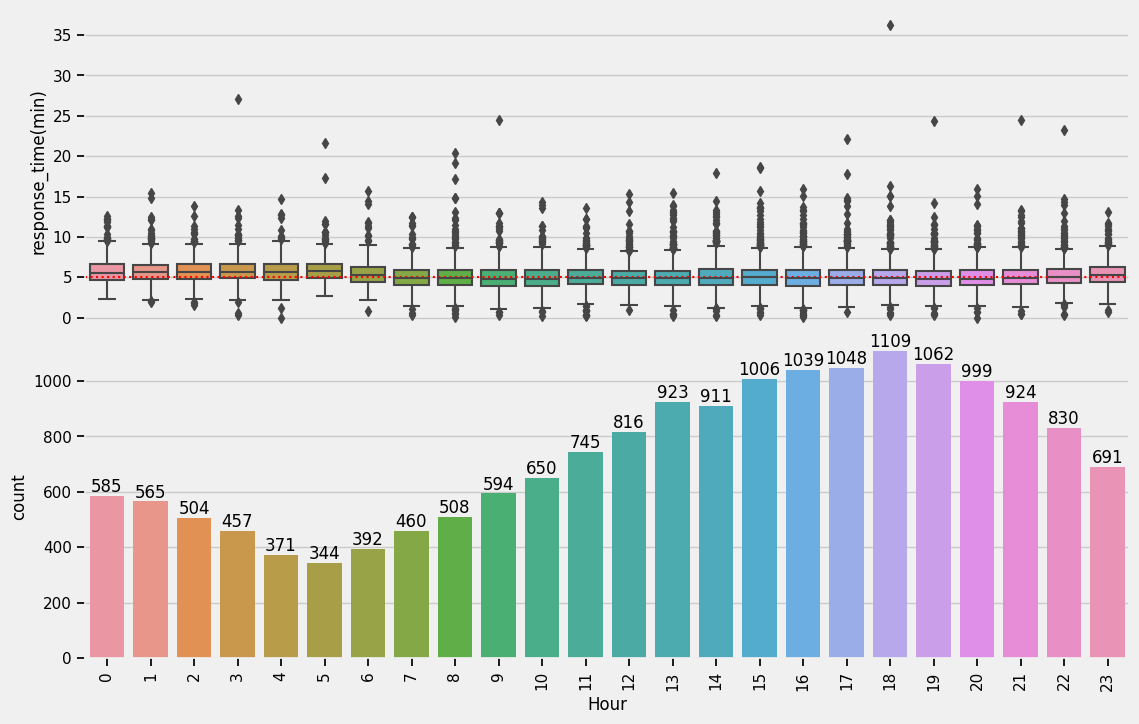

In [147]:
fig, axs = plt.subplots(nrows=2, figsize=(12, 8))

sns.boxplot(
    x='Hour',
    y='response_time(min)',
    data=fire_data.sort_values('Hour'),
    ax=axs[0]
)

sns.countplot(
    x='Hour',
    data=fire_data.sort_values('Hour'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=fire_data['response_time(min)'].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

In [111]:
byMonth=fire_data.groupby('Month').count()
byMonth.head(12)

,_id,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Number_of_responding_apparatus,Number_of_responding_personnel,TFS_Alarm_Time,TFS_Arrival_Time,geometry,Hour,Day of Week,Year,response_time(min)
Month,,,,,,,,,,,,,,
1,1437,1437,1437,1437,1437,1437,1437,1437,1437,1437,1437,1437,1437,1437
2,1279,1279,1279,1279,1279,1279,1279,1279,1279,1279,1279,1279,1279,1279
3,1612,1612,1612,1612,1612,1612,1612,1612,1612,1612,1612,1612,1612,1612
4,1699,1699,1699,1699,1699,1699,1699,1699,1699,1699,1699,1699,1699,1699
5,1926,1926,1926,1926,1926,1926,1926,1926,1926,1926,1926,1926,1926,1926
6,1822,1822,1822,1822,1822,1822,1822,1822,1822,1822,1822,1822,1822,1822
7,1592,1592,1592,1592,1592,1592,1592,1592,1592,1592,1592,1592,1592,1592
8,1279,1279,1279,1279,1279,1279,1279,1279,1279,1279,1279,1279,1279,1279
9,1214,1214,1214,1214,1214,1214,1214,1214,1214,1214,1214,1214,1214,1214


In [112]:
dayHour = fire_data.groupby(by=['Day of Week','Hour']).count()['_id'].unstack()
dayHour.head(7)

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Day of Week,,,,,,,,,,,,,,,,,,,,,
Fri,80,83,87,71,43,50,64,71,57,99,...,153,157,179,170,157,154,154,141,143,94
Mon,75,65,59,37,49,50,61,76,99,83,...,134,149,153,132,170,146,147,115,123,106
Sat,103,81,78,79,81,53,49,59,59,70,...,134,149,140,140,160,166,128,132,127,108
Sun,97,110,88,81,64,62,59,58,63,75,...,117,133,152,154,143,158,140,145,130,112
Thu,86,77,59,57,51,43,57,65,75,87,...,106,148,135,148,163,147,136,128,87,88
Tue,71,66,59,63,47,38,45,69,68,86,...,137,124,138,170,150,149,143,123,119,89
Wed,73,83,74,69,36,48,57,64,87,94,...,130,146,142,134,166,142,151,140,101,94


<AxesSubplot: xlabel='Hour', ylabel='Day of Week'>

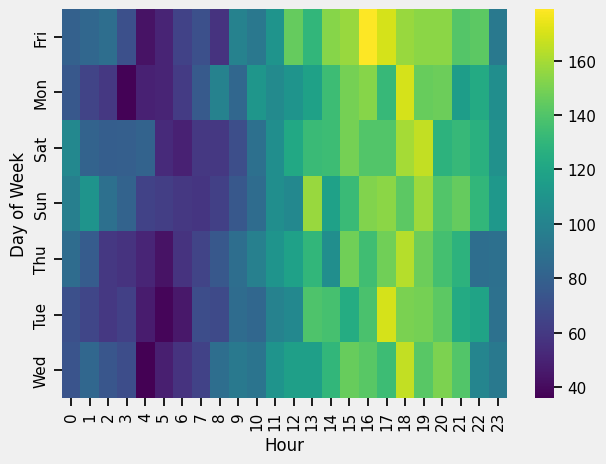

In [113]:
sns.heatmap(dayHour, cmap='viridis')


In [114]:
dayMonth = fire_data.groupby(by=['Day of Week','Month']).count()['_id'].unstack()
dayMonth.head()


Month,1,2,3,4,5,6,7,8,9,10,11,12
Day of Week,,,,,,,,,,,,
Fri,208,202,241,247,289,272,225,235,183,186,205,192
Mon,212,189,210,229,286,239,251,170,166,175,153,192
Sat,209,201,273,247,264,271,230,166,174,175,152,183
Sun,201,161,226,254,275,284,268,193,196,174,177,184
Thu,204,171,214,231,256,253,197,190,163,173,173,173


<AxesSubplot: xlabel='Month', ylabel='Day of Week'>

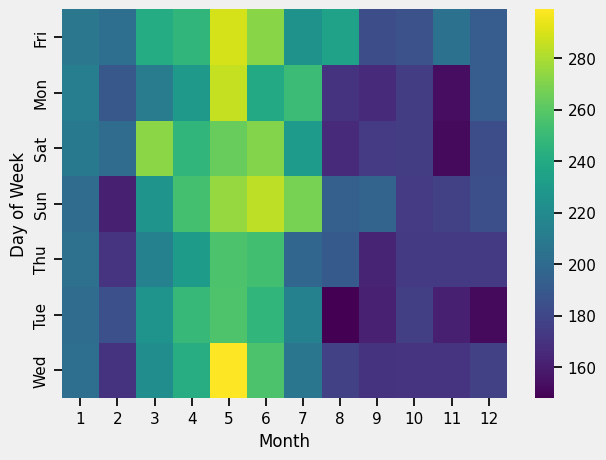

In [115]:
sns.heatmap(dayMonth, cmap='viridis')


In [116]:
monthYear = fire_data.groupby(by=['Month','Year']).count()['_id'].unstack()
monthYear.head(20)


Year,2011,2012,2013,2014,2015,2016,2017,2018,2019
Month,,,,,,,,,
1,131.0,159.0,151.0,175.0,148.0,142.0,132.0,190.0,209.0
2,131.0,107.0,122.0,149.0,158.0,125.0,129.0,184.0,174.0
3,173.0,164.0,125.0,161.0,166.0,141.0,147.0,302.0,233.0
4,135.0,206.0,150.0,184.0,177.0,161.0,157.0,271.0,258.0
5,142.0,174.0,174.0,190.0,206.0,192.0,150.0,395.0,303.0
6,166.0,152.0,147.0,162.0,135.0,203.0,152.0,363.0,342.0
7,187.0,180.0,166.0,143.0,170.0,201.0,155.0,390.0,NaN
8,163.0,149.0,153.0,150.0,115.0,124.0,153.0,272.0,NaN
9,135.0,122.0,136.0,115.0,121.0,146.0,167.0,272.0,NaN


<AxesSubplot: xlabel='Year', ylabel='Month'>

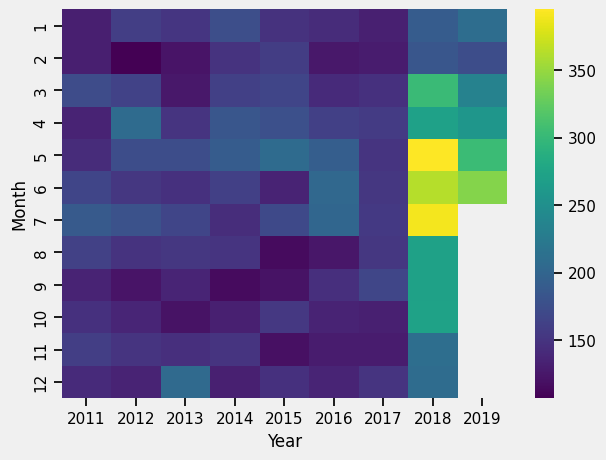

In [117]:
sns.heatmap(monthYear, cmap = 'viridis')


In [118]:
# fig, axes = plt.subplots(1,2,figsize =(20,10))
#
# sns.countplot(x='Year', data=fire_data,hue = 'Count_of_Persons_Rescued', palette='viridis', ax=axes[0])
# axes[0].set_title('People Rescued', size=20)
#
# sns.countplot(x='Year', data=fire_data,hue='Civilian_Casualties', palette='viridis', ax=axes[1])
# axes[1].set_title('Civilian Casulaties', size=20)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
#
# sns.despine(bottom=False, left=True)

In [119]:
# fire_data['Civilian_Casualties'].value_counts().head(40).to_frame(name='Counts').reset_index().style.background_gradient(cmap='Reds', subset='Counts')

In [120]:
# sns.countplot(x = 'Year',data = fire_data, hue ='TFS_Firefighter_Casualties', palette = 'viridis')


In [121]:
### Important Data! Identify Sation 426- near parkdale? Why is this station respondong most? close to most incidents?

In [122]:
# fire_data['Incident_Station_Area'].value_counts().head().to_frame(name='Count').reset_index().style.background_gradient(cmap='Reds', subset='Count')

In [123]:
# property_count = fire_data['Property_Use'].value_counts()
# property_count = property_count[:10]
# plt.figure(figsize = (20,10))
# sns.barplot(x=property_count.index,y=property_count.values, alpha=0.8, palette='cividis')
# plt.title('Top Property Use for Incidents', fontsize = 30)
# plt.xlabel('Property Use', fontsize = 20)
# plt.ylabel('Incidents', fontsize = 20)
# plt.xticks(rotation = 90)
# plt.show()

In [124]:
# fire_data['Property_Use'].value_counts()\
#                     .head()\
#                     .to_frame(name = 'Count')\
#                     .reset_index()\
#                     .style.background_gradient(cmap = 'Reds', subset='Count')

In [125]:
# fire_data['Material_First_Ignited'].value_counts()\
#                             .head(20)\
#                             .to_frame(name='Count')\
#                             .reset_index()\
#                             .style.background_gradient(cmap='Reds', subset='Count')

In [126]:
# material_count = fire_data['Material_First_Ignited'].value_counts()
# material_count = material_count[:10]
# plt.figure(figsize = (20,10))
# sns.barplot(x=material_count.index,y=material_count.values, alpha=0.8, saturation =1, palette='cividis')
# plt.title('Top Material first ignited for Incidents', fontsize = 30)
# plt.xlabel('Material', fontsize = 20)
# plt.ylabel('Incidents', fontsize = 20)
# plt.xticks(rotation = 90)
# plt.show()

In [127]:
fire_data['response_time(min)'] =fire_data['TFS_Arrival_Time'] - fire_data['TFS_Alarm_Time']
fire_data['response_time(min)'] = fire_data['response_time(min)'].dt.total_seconds()/60

In [128]:
fire_data.head()
# Day of the week is currently the only non-numerical value

,_id,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Number_of_responding_apparatus,Number_of_responding_personnel,TFS_Alarm_Time,TFS_Arrival_Time,geometry,Hour,Month,Day of Week,Year,response_time(min)
0,578689,441,1.0,43.686558,-79.599419,1,4,2018-02-24 21:04:29,2018-02-24 21:10:11,POINT (-79.59942 43.68656),21,2,Sat,2018,5.700000
1,578690,116,18.0,43.766135,-79.390039,1,4,2018-02-24 21:24:43,2018-02-24 21:29:31,POINT (-79.39004 43.76613),21,2,Sat,2018,4.800000
2,578691,221,21.0,43.743230,-79.245061,6,22,2018-02-25 13:29:59,2018-02-25 13:36:49,POINT (-79.24506 43.74323),13,2,Sun,2018,6.833333
3,578692,133,5.0,43.708659,-79.478062,6,22,2018-02-25 14:13:39,2018-02-25 14:18:07,POINT (-79.47806 43.70866),14,2,Sun,2018,4.466667
4,578693,132,8.0,43.718118,-79.443184,6,22,2018-02-25 18:20:43,2018-02-25 18:26:19,POINT (-79.44318 43.71812),18,2,Sun,2018,5.600000


In [129]:
correlation = fire_data.corr()

In [130]:
correlation

,_id,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Number_of_responding_apparatus,Number_of_responding_personnel,Hour,Month,Year,response_time(min)
_id,1.000000,0.031067,0.266491,-0.011211,-0.020516,0.239713,0.240757,-0.021054,0.108277,-0.541894,-0.024452
Incident_Station_Area,0.031067,1.000000,-0.385851,-0.640792,-0.435927,0.013145,0.010853,-0.033128,-0.012594,-0.016677,-0.018602
Incident_Ward,0.266491,-0.385851,1.000000,0.358098,0.868665,0.049138,0.053826,-0.004370,0.042478,-0.261602,0.001431
Latitude,-0.011211,-0.640792,0.358098,1.000000,0.349856,-0.008821,-0.002550,0.035473,-0.000244,-0.004678,0.057220
Longitude,-0.020516,-0.435927,0.868665,0.349856,1.000000,0.006874,0.010269,0.007278,0.003380,0.015600,0.004925
Number_of_responding_apparatus,0.239713,0.013145,0.049138,-0.008821,0.006874,1.000000,0.996649,-0.064697,-0.013240,-0.066093,-0.026269
Number_of_responding_personnel,0.240757,0.010853,0.053826,-0.002550,0.010269,0.996649,1.000000,-0.061478,-0.014191,-0.061367,-0.026611
Hour,-0.021054,-0.033128,-0.004370,0.035473,0.007278,-0.064697,-0.061478,1.000000,-0.005409,0.001848,-0.039195
Month,0.108277,-0.012594,0.042478,-0.000244,0.003380,-0.013240,-0.014191,-0.005409,1.000000,-0.101242,-0.000364
Year,-0.541894,-0.016677,-0.261602,-0.004678,0.015600,-0.066093,-0.061367,0.001848,-0.101242,1.000000,-0.006097


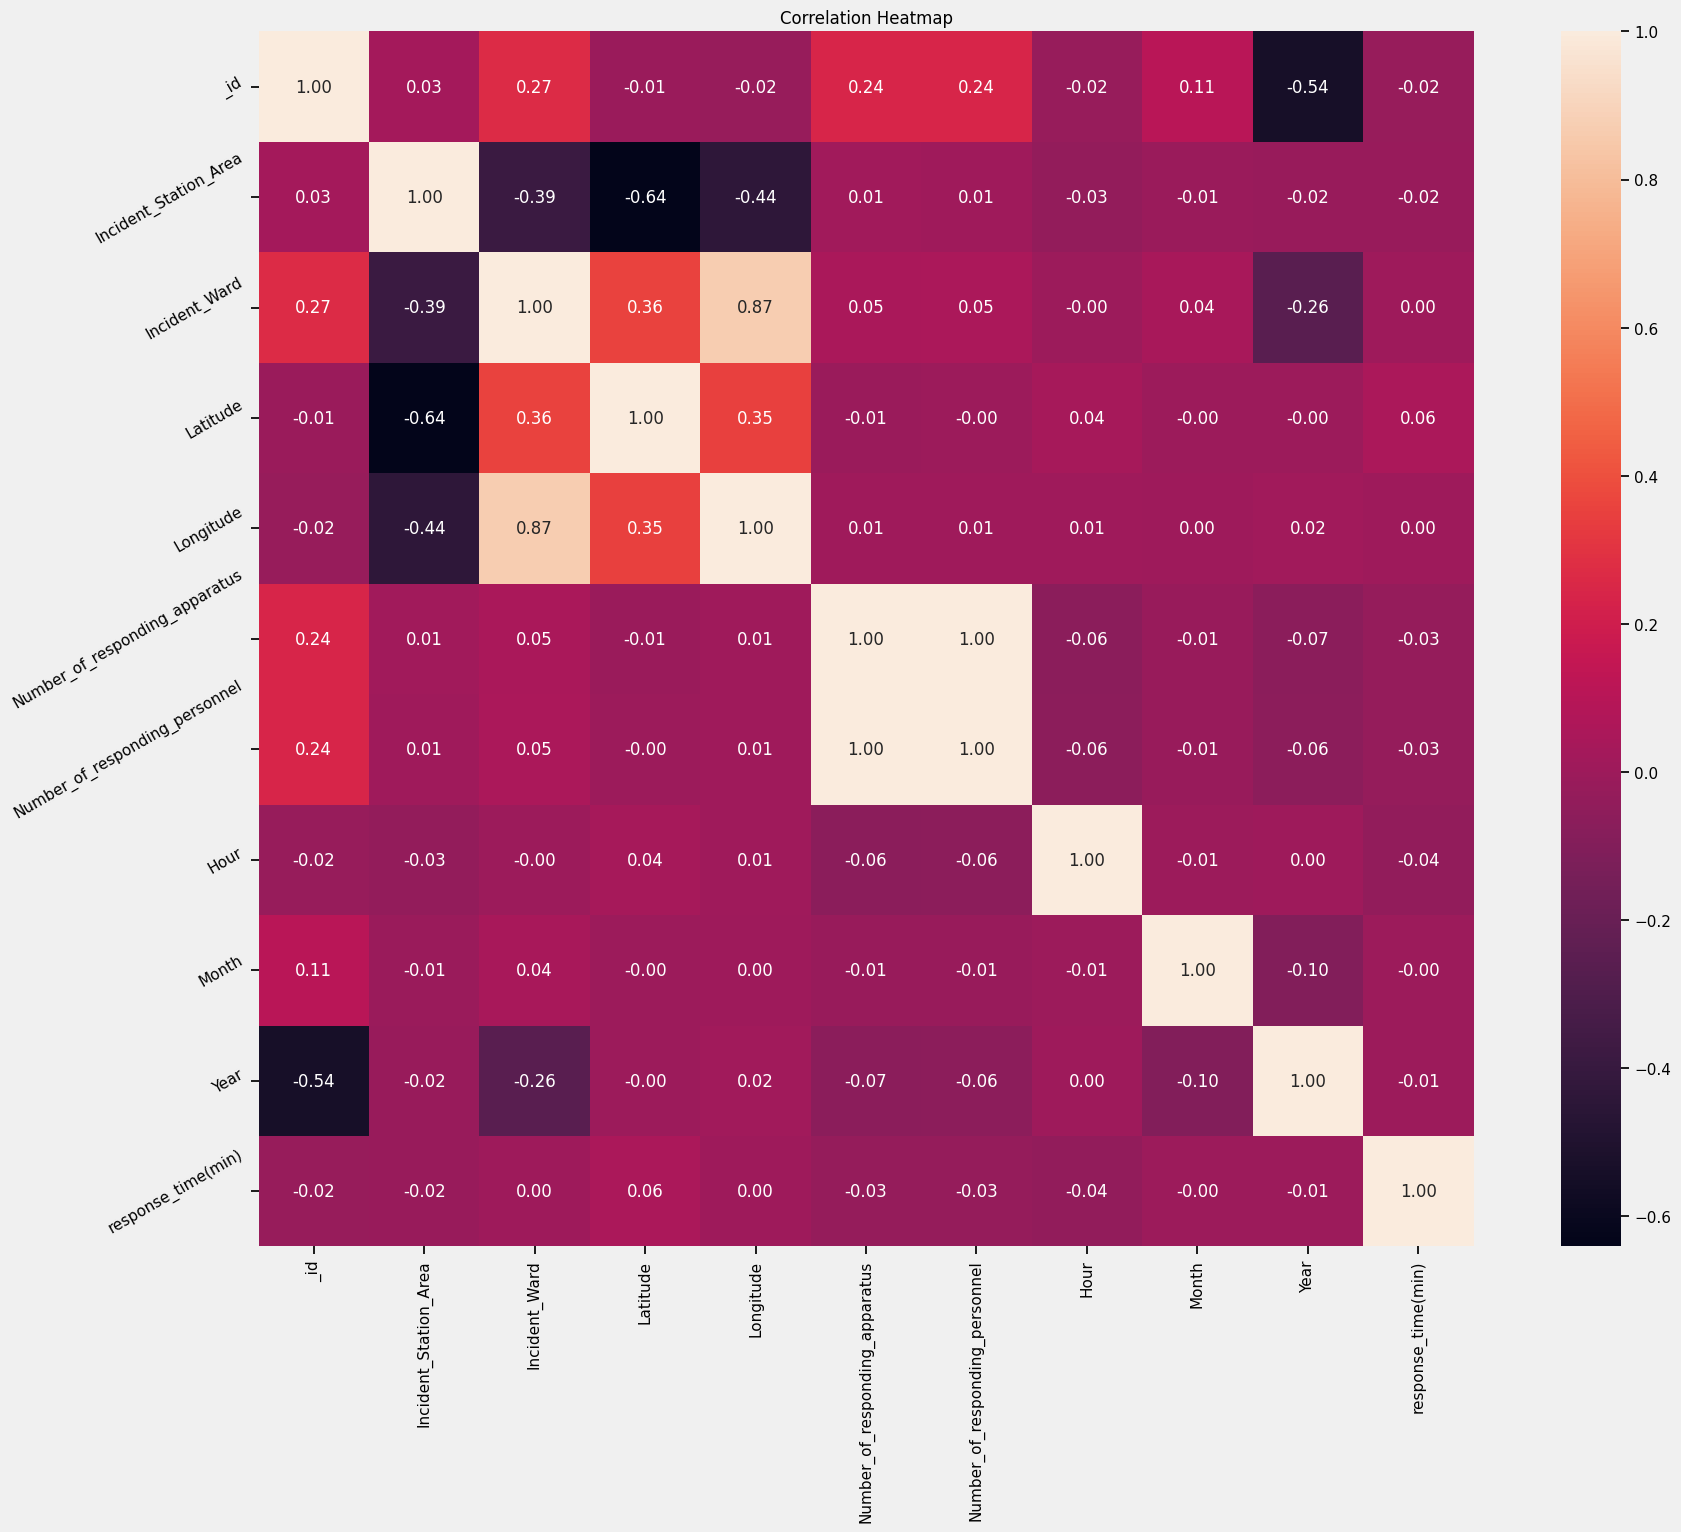

In [131]:
#graphing the matrix
plt.figure(figsize=(20,15))
plt.title('Correlation Heatmap')#title
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

In [132]:
# Predict how long it takes for TFS to respond to incidents
# Try distnace instead of lat/long

X = fire_data[['Latitude','Longitude', 'Hour', 'Year']]
y = fire_data[['response_time(min)']]


# normalize or standardize the data
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

# split the data into train and test
# set aside 20% of train for evaluation
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)
# Create validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)


In [133]:
#helper function to evaluate a model
from sklearn.metrics import mean_squared_error
def evaluate_model(model, model_name = None):
    model.fit(X_train,y_train)
    pred = model.predict(X_val)
    error = mean_squared_error(y_val, pred)
    if model_name is not None:
        print("Error for %s, : %.6f"%(model_name, error))
    return error

In [134]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import neighbors
from sklearn import tree
from sklearn import svm
models =[LinearRegression(),linear_model.Ridge(),\
         neighbors.KNeighborsRegressor(5,weights='uniform'), linear_model.BayesianRidge(),\
         tree.DecisionTreeRegressor(max_depth=4),svm.SVR(gamma = 'auto')]
tags = ["LinearRegression","Ridge", 'knn5', "BayesianRidge", 'tree4','svr']
for model,tag in zip(models,tags):
    error = evaluate_model(model,tag)

Error for LinearRegression, : 27.396656
Error for Ridge, : 27.396662
Error for knn5, : 43.114788
Error for BayesianRidge, : 27.405691
Error for tree4, : 155.234752
Error for svr, : 27.171654
